In [7]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time


In [8]:
import decoupler as dc
import pandas as pd
import sys
import pickle
import tqdm
import scipy
import matplotlib


In [9]:
# https://github.com/johannesbjork/LaCroixColoR pamplemousse
colors = ["#EA7580","#F6A1A5","#F8CD9C","#1BB6AF","#088BBE","#172869"]

# Convenience functions

In [10]:
import pickle
with open('/home/ec2-user/curation/heart_datasets/gg_250327_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load( fp)

In [23]:
neuron_cts = ['Glia','glia','neuron','Neuron','neural','Neural','Schwann']

def get_df(ads,gene,setting):
    dfs = {}
    for i,dataset in enumerate(ads.keys()):
        ad = ads[dataset]
        
    
        if 'age' in ad.obs.columns:
            df = ad.obs[['donor_id','sex','age']].drop_duplicates().reset_index(drop=True).set_index('donor_id')
        elif 'Age_bin' in ad.obs.columns:
            df = ad.obs[['donor_id','sex','Age_bin']].drop_duplicates().reset_index(drop=True).set_index('donor_id')
        donor_ids = list(df.index)

        if setting == 'xist':
            filt=ad.obs['xist']=='present'
        if setting == 'cell_type':
            filt=ad.obs['cell_type'].str.contains( "|".join(neuron_cts),regex=True)
    
        df['gex_selected']=None
        df['gex_others']=None
        # mn = []
        # mnn = []
        try:
            for donor_id in donor_ids:
                filt_donor = filt&(ad.obs['donor_id']==donor_id)
                m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
                
                filt_nonneur_donor = (~filt)&(ad.obs['donor_id']==donor_id)        
                m_nonneur = np.array(ad[filt_nonneur_donor,gene].X).sum()/ad.obs.loc[filt_nonneur_donor,'psbulk_n_cells'].sum()
        
                df.loc[donor_id,'gex_selected'] = m_neur
                df.loc[donor_id,'gex_others'] = m_nonneur
        except:
            pass
        dfs[dataset]=df
    return dfs
c_neur_m = colors[0]
c_nonneur_m=colors[2]
c_neur_f = colors[5]
c_nonneur_f=colors[3]

def plot_df(dfs,gene,ax1,linthresh=1e-5,hideticklabels=False,ylabel_suffix=' average expression'):
# for i,dataset in enumerate(['tucker']):
    for i,dataset in enumerate(dfs.keys()):
        df = dfs[dataset]
        male_donors = df['sex']=='male'
        nMale = male_donors.sum()
        x = np.array([i]*nMale)
    
    
        bw = 0.14
        jit_bw = 0.01
        jit = np.random.randn(len(x))*jit_bw
        ax1.scatter(x -(bw*1.5)+jit, df.loc[male_donors,'gex_selected'],c=c_neur_m,alpha=0.4,marker='^')
        ax1.scatter(x -(bw*0.5)+jit, df.loc[male_donors,'gex_others'],c=c_nonneur_m,alpha=0.4,marker='^')
        
        female_donors = df['sex']=='female'
        nFemale = female_donors.sum()
        x = np.array([i]*nFemale)
        
        jit = np.random.randn(len(x))*jit_bw
        ax1.scatter(x +(bw*0.5)+jit, df.loc[female_donors,'gex_selected'],c=c_neur_f,alpha=0.4,marker='.')
        ax1.scatter(x + (bw*1.5)+jit, df.loc[female_donors,'gex_others'],c=c_nonneur_f,alpha=0.4,marker='.')
    
    # ax1.set_yscale('symlog',linthresh=1e-3)
    ax1.set_yscale('symlog',linthresh=linthresh)
    # ax1.set_xticks([])
    ax1.set_ylabel(r'$\it{'+gene+'}$'+ylabel_suffix)
    if hideticklabels:
        ax1.set_xticks(range(len(dfs)),[]*len(dfs),rotation=45)
    else:
        ax1.set_xticks(range(len(dfs)),list(dfs.keys()),rotation=45)

def plot_df_age(dfs,gene,ax1,linthresh=1e-5,agelim=[-2,100],
                legend=True,cmap='tab20c',ylabel_suffix=' average expression',
                sex='male',cellpop='gex_selected'):
    colors = matplotlib.colormaps[cmap](np.linspace(0,1,len(dfs)))
    ax1.set_prop_cycle('color', colors)

    for i,dataset in enumerate(dfs.keys()):
        print(dataset)
        df = dfs[dataset]
        donors = df['sex']==sex
        n_donors = donors.sum()
    
        if 'age' in df.columns:
            x = df.loc[donors,'age'].values
        elif 'Age_bin' in df.columns:
            x1 = df.loc[donors,'Age_bin'].str.split('-').str[1].astype(float)
            x2 = df.loc[donors,'Age_bin'].str.split('-').str[0].astype(float)
            x = (x1+x2)/2
            x = x.values

        # print(x)
        bw = 0.14
        jit_bw = 0.5
        jit = np.random.randn(len(x))*jit_bw
        x+=jit
        # print(donors)
        # print(cellpop)
        ax1.scatter(x, df.loc[donors,cellpop],alpha=0.4,label=dataset)
            
    ax1.set_yscale('symlog',linthresh=linthresh)
    # ax1.set_xticks([])
    ax1.set_ylabel(r'$\it{'+gene+'}$'+ylabel_suffix)
    ax1.set_xlim(agelim)
    if legend: ax1.legend()
    ax1.set_xlabel('Donor age')
    # if hideticklabels:
    #     ax1.set_xticks(range(len(dfs)),[]*len(dfs),rotation=45)
    # else:
    #     ax1.set_xticks(range(len(dfs)),list(dfs.keys()),rotation=45)

# Plotting

/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()


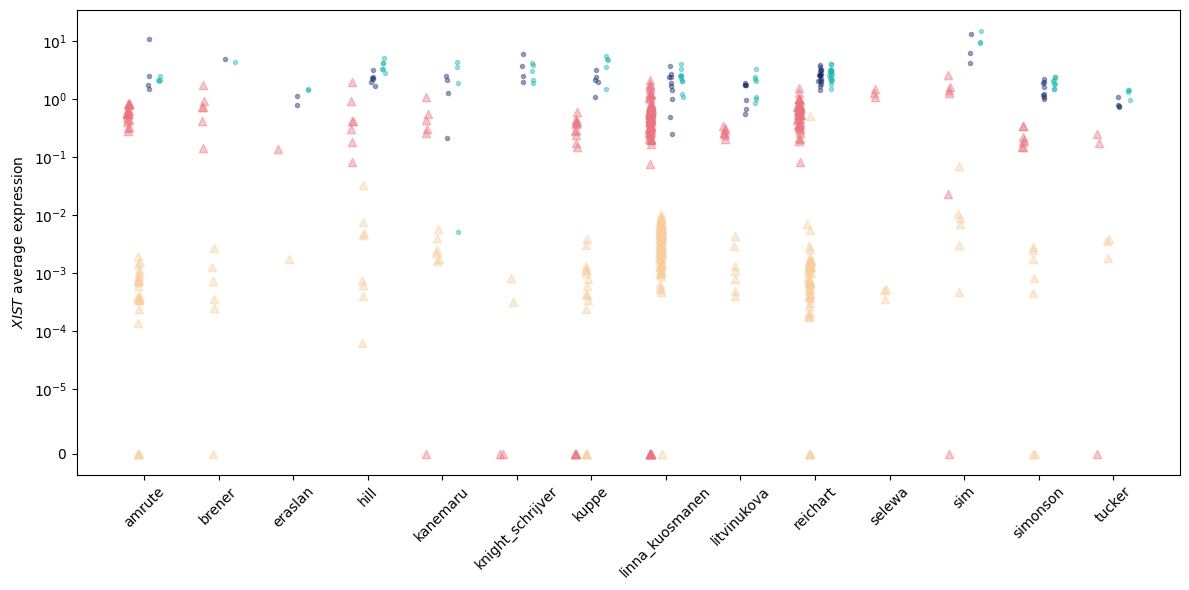

In [91]:
gene='XIST'
dfs = get_df(ads,gene,'cell_type')
fig1,ax1=plt.subplots(1,1,figsize=(12,6))
plot_df(dfs,gene,ax1,hideticklabels=False)
fig1.tight_layout()

In [92]:
with open('/home/ec2-user/curation/heart_datasets/gg_250328_male_glia_deseq.anndata.p', 'rb') as fp:
    dds_m=pickle.load(fp)

In [93]:
donors_df = pd.concat([pd.Series((dfs[x][dfs[x].sex=='male'].index+'_'+x).str.replace('_','-')) for x in dfs.keys()])

In [94]:
dfs['linna_kuosmanen'].loc[['CB-F35']]

,sex,Age_bin,gex_selected,gex_others
donor_id,,,,
CB-F35,male,70-79,1.0,0.001831


In [95]:
donors_df[~donors_df.isin(dds_m.obs['donor-id'])]

20     TWCM-378-NR-post-amrute
5                     P26-hill
3                  D3-kanemaru
0     BRC2251-knight-schrijver
1     BRC2262-knight-schrijver
1                    P10-kuppe
3                    P13-kuppe
5                    P16-kuppe
7                    P19-kuppe
2       CB-B84-linna-kuosmanen
5       CB-F35-linna-kuosmanen
7       CB-F45-linna-kuosmanen
11      CB-H69-linna-kuosmanen
12      CB-J15-linna-kuosmanen
24      CB-Q04-linna-kuosmanen
38      CB-Z48-linna-kuosmanen
74      PH-Q25-linna-kuosmanen
84      PH-W93-linna-kuosmanen
88      PH-U41-linna-kuosmanen
89      PH-Y03-linna-kuosmanen
3             SAMN15889156-sim
2                  1702-tucker
Name: donor_id, dtype: object

In [97]:
df = pd.concat(list(dfs.values()))

In [98]:
df = df[df['sex']=='female']

In [99]:
df

,sex,age,gex_selected,gex_others,Age_bin
donor_id,,,,,
TWCM-296-R-post,female,60,1.714286,2.13762,NaN
TWCM-296-R-pre,female,60,2.533333,2.043347,NaN
TWCM-397-NR-post,female,47,1.461538,2.14477,NaN
TWCM-397-NR-pre,female,47,10.7,2.541453,NaN
15_144548-RV,female,69,4.888889,4.381855,NaN
...,...,...,...,...,...
P1733,female,64,1.9375,2.432842,NaN
1221,female,52,0.779221,1.413248,NaN
1600,female,51,0.761194,0.967029,NaN


In [100]:
print((df['gex_selected']>0.01).sum())
print((df['gex_selected']<=0.01).sum())

76
0


In [101]:
len(dfs)

14

/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()


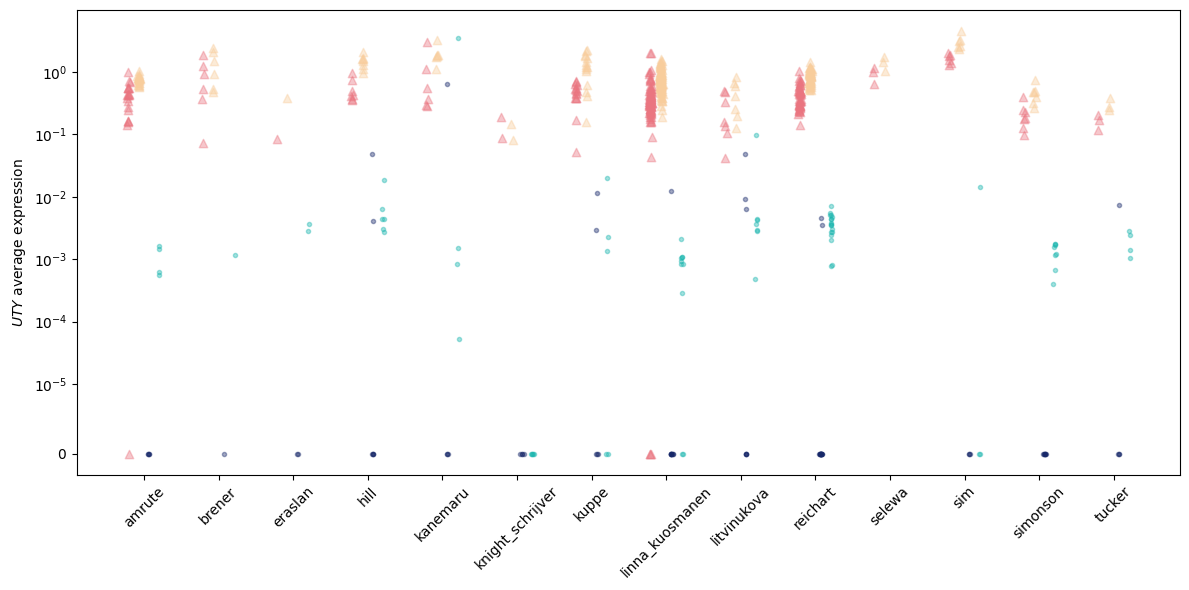

In [103]:
gene='UTY'
dfs = get_df(ads,gene,'cell_type')
fig1,ax1=plt.subplots(1,1,figsize=(12,6))
plot_df(dfs,gene,ax1,hideticklabels=False)
fig1.tight_layout()

/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeW

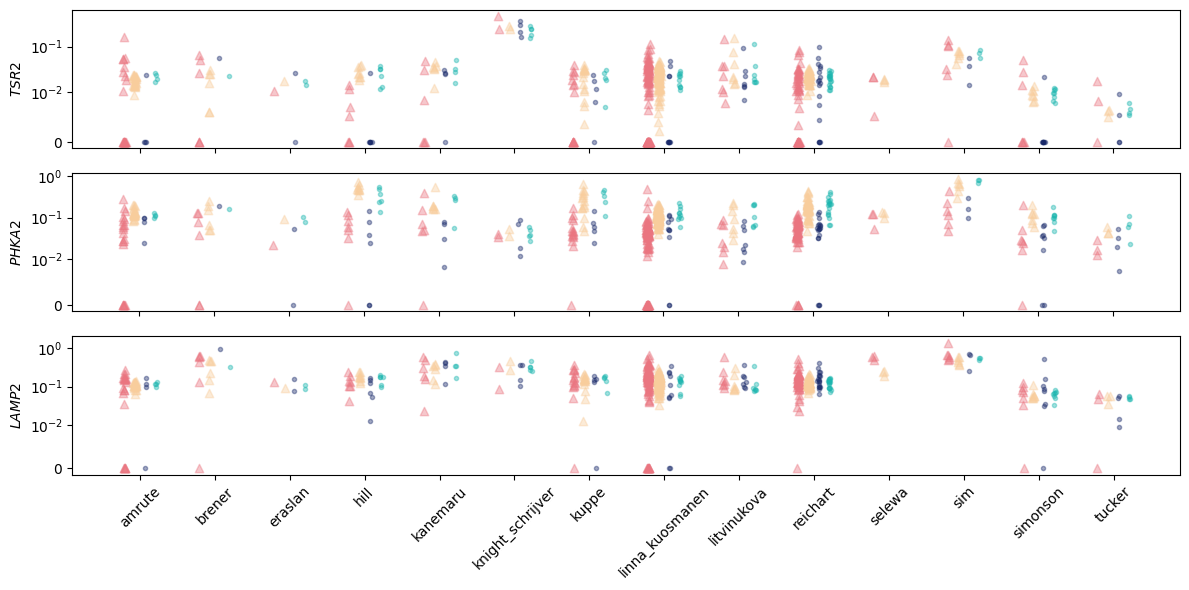

In [31]:
genes=['TSR2','PHKA2','LAMP2']
fig1,ax1=plt.subplots(3,1,figsize=(12,6))
for i,gene in enumerate(genes):
    dfs = get_df(ads,gene,'cell_type')
    
    plot_df(dfs,gene,ax1[i],hideticklabels=(i<(len(genes)-1)),linthresh=1e-2,ylabel_suffix='')
fig1.tight_layout()

/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeW

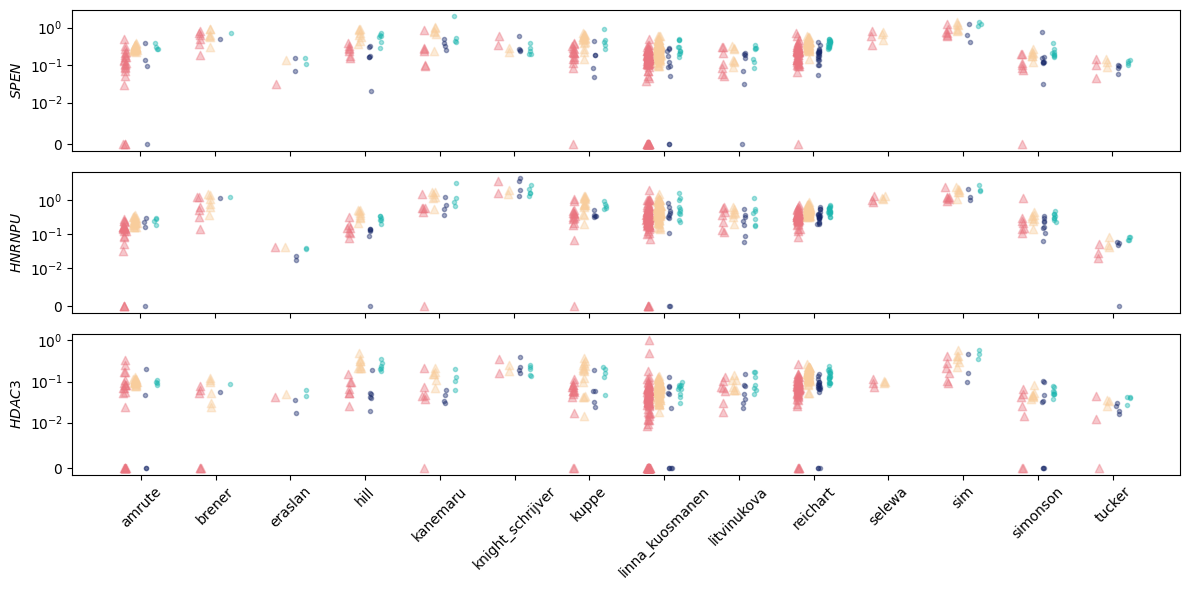

In [32]:
genes=['SPEN','HNRNPU','HDAC3']
fig1,ax1=plt.subplots(3,1,figsize=(12,6))
for i,gene in enumerate(genes):
    dfs = get_df(ads,gene,'cell_type')
    
    plot_df(dfs,gene,ax1[i],hideticklabels=(i<(len(genes)-1)),linthresh=1e-2,ylabel_suffix='')
fig1.tight_layout()

/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()
/tmp/ipykernel_6701/799596004.py:27: RuntimeWarning: invalid value encountered in scalar divide
  m_neur = np.array(ad[filt_donor,gene].X).sum()/ad.obs.loc[filt_donor,'psbulk_n_cells'].sum()


amrute
brener
eraslan
hill
kanemaru
knight_schrijver
kuppe
linna_kuosmanen
litvinukova
reichart
selewa
sim
simonson
tucker


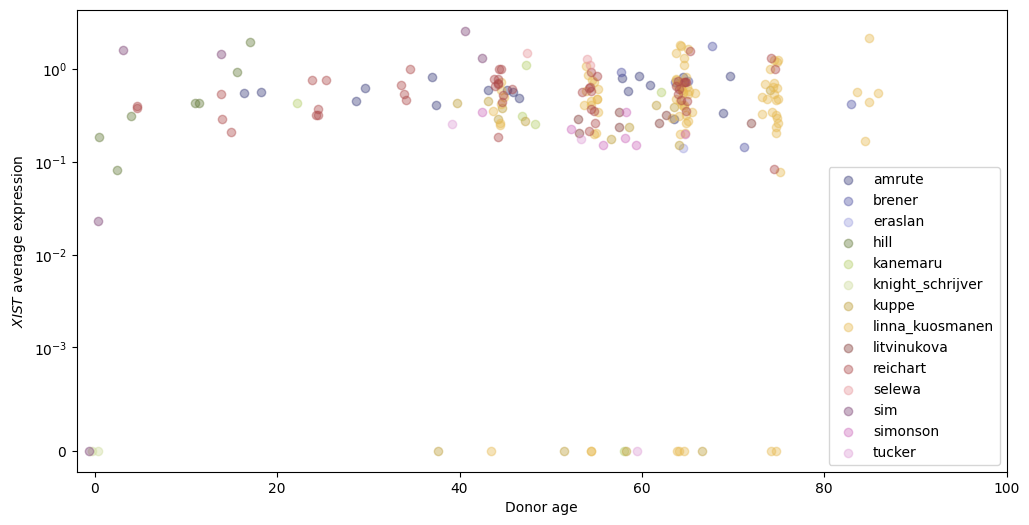

In [33]:
gene='XIST'
dfs = get_df(ads,gene,'cell_type')
fig1,ax1=plt.subplots(1,1,figsize=(12,6))
plot_df_age(dfs,gene,ax1,legend=True,cmap='tab20b',linthresh=1e-3)

In [34]:
x=[len(x) for x in dfs.values()]

In [35]:
sum(x)

302

In [36]:
sum([len(x[x['sex']=='male']) for x in dfs.values()])
# sum([len(x[x['sex']=='female']) for x in dfs.values()])

225

In [37]:
dfs['sim']

,sex,age,gex_selected,gex_others
donor_id,,,,
SAMN15889151,male,14.0,1.448,0.007079
SAMN15889152,female,10.0,4.114286,9.53367
SAMN15889153,male,4.0,1.593137,0.008901
SAMN15889154,female,0,13.045872,14.836561
SAMN15889155,male,0,0.023077,0.000475
SAMN15889156,male,0,0.0,0.003004
SAMN15889157,male,42.0,1.285714,0.069797
SAMN15889158,male,41.0,2.55814,0.01045
SAMN15889159,female,35.0,6.163636,9.14216


In [38]:
sum(x)

302